In [34]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pyvis.network import Network

In [2]:
df = pd.read_csv("data/Groceries_dataset.csv")
df.set_index("Member_number", inplace=True)

In [3]:
df.head()

,Date,itemDescription
Member_number,,
1808,21-07-2015,tropical fruit
2552,05-01-2015,whole milk
2300,19-09-2015,pip fruit
1187,12-12-2015,other vegetables
3037,01-02-2015,whole milk


In [7]:
df = df.groupby(["Member_number"])["itemDescription"].apply(list).tolist()

In [8]:
te = TransactionEncoder()

In [10]:
te_arr = te.fit(df).transform(df)

In [11]:
df_en = pd.DataFrame(te_arr, columns=te.columns_)

In [12]:
df_en

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,True,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3893,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3894,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
3895,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3896,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,True,False


In [40]:
freq_item = apriori(df_en, min_support=0.02, use_colnames=True)

In [41]:
rules = association_rules(freq_item, metric="lift", min_threshold=1.2)

(np.float64(-0.9031818429352293),
 np.float64(0.9839325919591401),
 np.float64(-1.203213479469638),
 np.float64(1.1385799506090482))

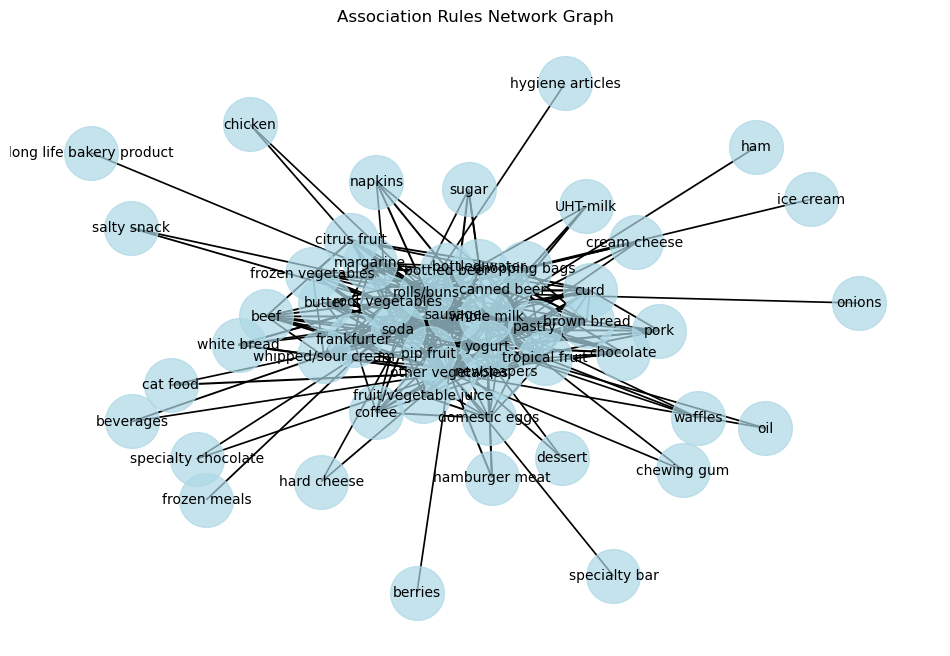

In [42]:
G = nx.Graph()

for _, row in rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['lift'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, seed=42) 

nx.draw_networkx_nodes(G, pos, node_size=1500, node_color="lightblue", alpha=0.7)

edges = G.edges(data=True)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[d['weight'] for (_,_,d) in edges])

nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

plt.title("Association Rules Network Graph")
plt.axis("off")

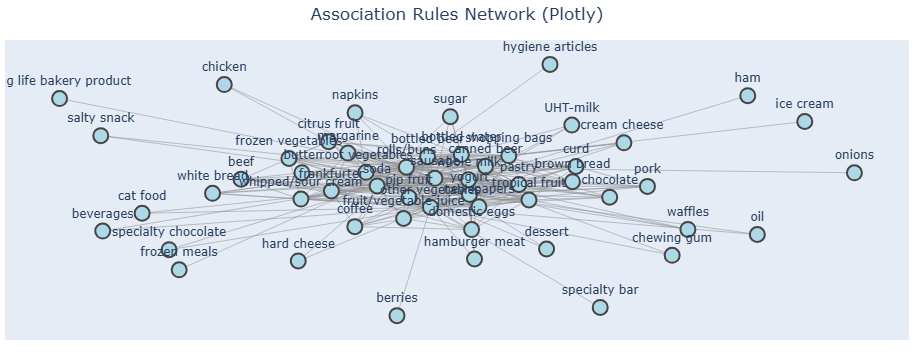

In [27]:
edge_x, edge_y = [], []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

node_x, node_y = [], []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=list(G.nodes()),
    textposition="top center",
    hoverinfo='text',
    marker=dict(
        showscale=False,
        color="lightblue",
        size=15,
        line_width=2))

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Association Rules Network (Plotly)",
                    title_x=0.5,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()

In [61]:
net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white")

for _, row in rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            net.add_node(antecedent, label=antecedent, color="lightblue")
            net.add_node(consequent, label=consequent, color="orange")
            net.add_edge(antecedent, consequent, value=row['lift'])

net.show("association_rules_aprori.html")

association_rules_aprori.html


In [62]:
rules_sorted = rules.sort_values(by="lift", ascending=False).head(30)

net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", directed=True, notebook=True)
net.barnes_hut(gravity=-20000, central_gravity=0.3, spring_length=200, spring_strength=0.05)

for _, row in rules_sorted.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            net.add_node(antecedent, label=antecedent, color="lightblue")
            net.add_node(consequent, label=consequent, color="orange")
            net.add_edge(
                antecedent, consequent,
                value=row['lift'],  # thickness by lift
                title=f"support: {row['support']:.2f}, confidence: {row['confidence']:.2f}, lift: {row['lift']:.2f}"
            )

net.show("association_rules_apriori_static_30.html")

association_rules_apriori_static_30.html


In [47]:
freq_fp = fpgrowth(df_en, min_support=0.02, use_colnames=True)

In [48]:
rules = association_rules(freq_fp, min_threshold=1.2, metric="lift")

(np.float64(-1.2002051164515601),
 np.float64(1.106920511228322),
 np.float64(-0.9184724024794625),
 np.float64(0.942982979287996))

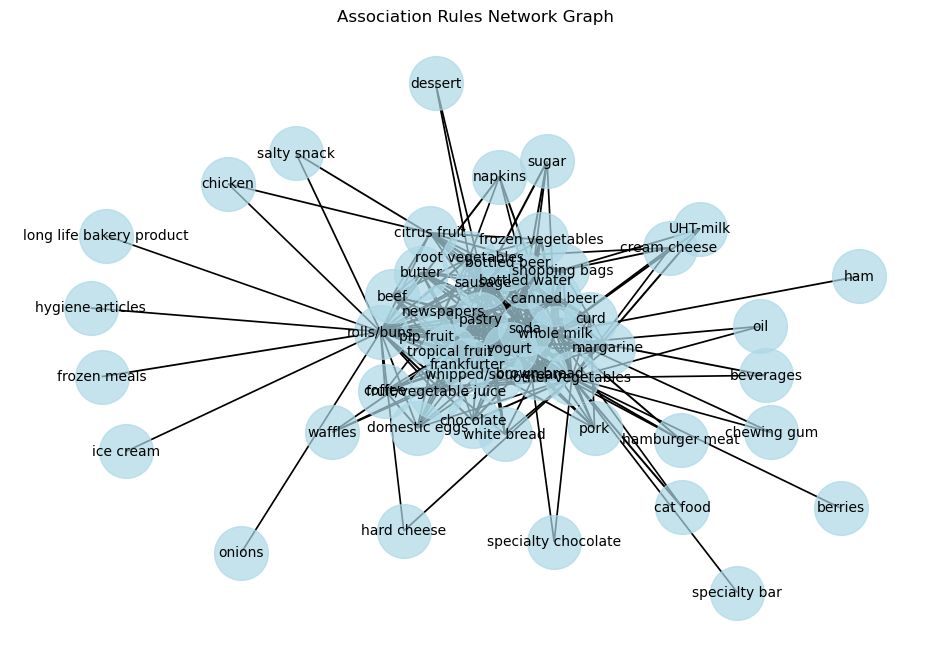

In [68]:
G = nx.Graph()

for _, row in rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['lift'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, seed=42) 

nx.draw_networkx_nodes(G, pos, node_size=1500, node_color="lightblue", alpha=0.7)

edges = G.edges(data=True)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[d['weight'] for (_,_,d) in edges])

nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

plt.title("Association Rules Network Graph")
plt.axis("off")

(np.float64(-1.2002051164515601),
 np.float64(1.106920511228322),
 np.float64(-0.9184724024794625),
 np.float64(0.942982979287996))

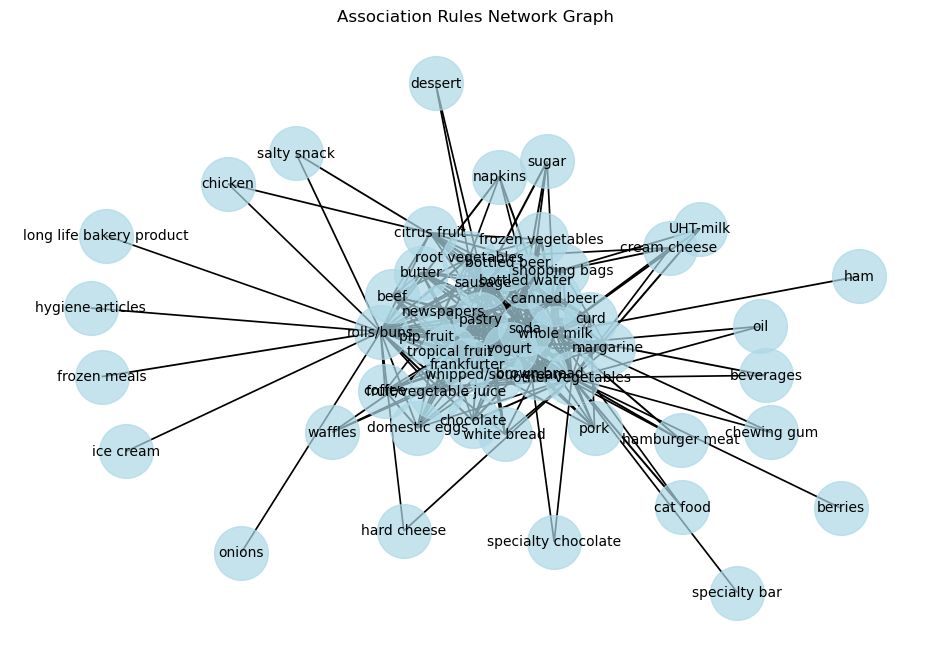

In [50]:
G = nx.Graph()

for _, row in rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['lift'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, seed=42) 

nx.draw_networkx_nodes(G, pos, node_size=1500, node_color="lightblue", alpha=0.7)

edges = G.edges(data=True)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[d['weight'] for (_,_,d) in edges])

nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

plt.title("Association Rules Network Graph")
plt.axis("off")

In [51]:
net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white")

for _, row in rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            net.add_node(antecedent, label=antecedent, color="lightblue")
            net.add_node(consequent, label=consequent, color="orange")
            net.add_edge(antecedent, consequent, value=row['lift'])

net.show("association_rules_fpgrowth.html")

association_rules_fpgrowth.html


In [69]:
rules_sorted = rules.sort_values(by="lift", ascending=False).head(30)

net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", directed=True, notebook=True)
net.barnes_hut(gravity=-20000, central_gravity=0.3, spring_length=200, spring_strength=0.05)

for _, row in rules_sorted.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            net.add_node(antecedent, label=antecedent, color="lightblue")
            net.add_node(consequent, label=consequent, color="orange")
            net.add_edge(
                antecedent, consequent,
                value=row['lift'], 
                title=f"support: {row['support']:.2f}, confidence: {row['confidence']:.2f}, lift: {row['lift']:.2f}"
            )

net.show("association_rules_fpgrowth_static_30.html")

association_rules_fpgrowth_static_30.html


In [74]:
net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", directed=True, notebook=True)

for _, row in rules_sorted.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            net.add_node(antecedent, label=antecedent, color="lightblue")
            net.add_node(consequent, label=consequent, color="orange")
            net.add_edge(
                antecedent, consequent,
                value=row['lift'],
                title=f"support: {row['support']:.2f}, "
                      f"confidence: {row['confidence']:.2f}, "
                      f"lift: {row['lift']:.2f}"
            )

net.set_options("""
{
  "physics": {
    "enabled": true,
    "barnesHut": {
      "gravitationalConstant": -200000,
      "centralGravity": 0.001,
      "springLength": 800,
      "springConstant": 0.02,
      "springstrength": 2
    }
  },
  "interaction": { "dragNodes": true },
  "layout": { "improvedLayout": true }
}
""")

net.show("association_rules_fpgrowth_slow_rotate.html")


association_rules_fpgrowth_slow_rotate.html
